In [1]:
import os
import pandas as pd

df_wine = pd.read_csv(os.path.join('..', '..', 'data', 'input', 'wine.data'), header=None)

In [2]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [3]:
import numpy as np

np.set_printoptions(precision=7)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV %s: %s\n' %(label, mean_vecs[label-1]))

MV 1: [ 0.9065826 -0.3497346  0.3201033 -0.7189145  0.5055868  0.880697
  0.9589471 -0.5516105  0.5415932  0.2338311  0.589713   0.656314
  1.2074938]

MV 2: [-0.8748796 -0.2848    -0.3734723  0.3157123 -0.3848035 -0.043325
  0.0634532 -0.0946061  0.0703475 -0.8286047  0.3143696  0.3608426
 -0.7252864]

MV 3: [ 0.199215   0.8660339  0.168163   0.4148449 -0.0451177 -1.0285553
 -1.2875603  0.8286769 -0.7794757  0.9649443 -1.2089913 -1.3621516
 -0.4013008]



In [13]:
# within scatter matrix
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
for row in X_train_std[y_train==label]:
    row, mv = row.reshape(d, 1), mv.reshape(d, 1)
    class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
print('Within-class scatter matrix: %sx%s' %(S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [14]:
print('Class label distribution: %s' % np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


In [24]:
# within scatter matrix with normalization
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print('Within-class scatter matrix: %sx%s' %(S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [25]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train==i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n*(mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


In [26]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [27]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

eigenvalues in descending order:

349.61780890599397
172.76152218979385
6.769227387336713e-14
2.842170943040401e-14
2.795501403069167e-14
2.795501403069167e-14
2.2176779251328635e-14
2.2176779251328635e-14
2.141227157435516e-14
1.548055091704145e-14
1.548055091704145e-14
4.025471054453907e-15
1.6506353401336048e-15


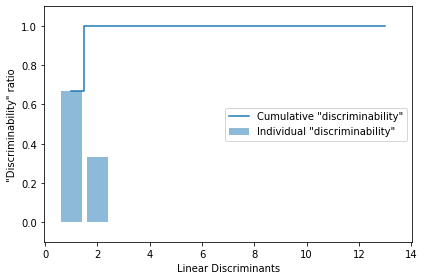

In [31]:
import matplotlib.pyplot as plt
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='Individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid', label='Cumulative "discriminability"')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [33]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1480827 -0.4091867]
 [ 0.0907694 -0.1576598]
 [-0.016782  -0.3537124]
 [ 0.148401   0.3223157]
 [-0.0163456 -0.0816897]
 [ 0.1913076  0.0841916]
 [-0.7337755  0.2823496]
 [-0.0750199 -0.0101564]
 [ 0.0018493  0.0906502]
 [ 0.2940274 -0.2152308]
 [-0.0328263  0.2747098]
 [-0.3546691 -0.0124387]
 [-0.3915156 -0.5957869]]


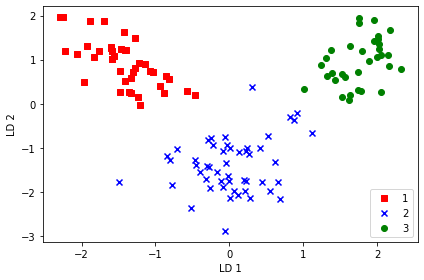

In [37]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1]*-1, c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

In [42]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot examples by class
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

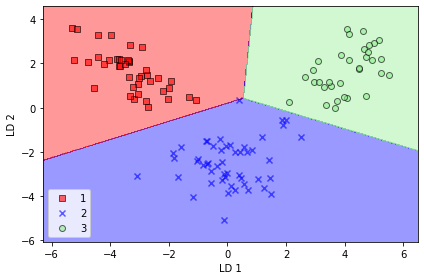

In [44]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

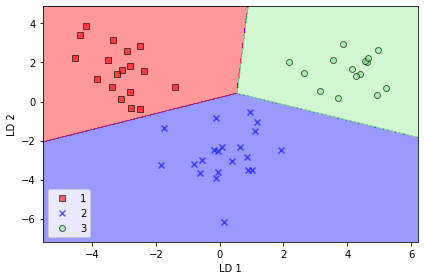

In [46]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()